# Final Project Baseline: House Prices- Advanced Regression Techniques
### Author: Radia Abdul Wahab, Parham Motameni, Jun Qian
### Date: Fall 2021
### Course: w207 Machine Learning







## Supplementary Notebook for Various Linear Regression Models, Hyperparameter tuning and RMSE assessment. 

In [35]:
# This tells matplotlib not to try opening a new window for each plot.
from pathlib import Path
import seaborn as sns
import pandas as pd
import random
import warnings

import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.feature_selection import RFE


# internal modules
from base_regressor_plot import BaseRegressorPlot
from configurations import args
from data_loader import DataLoader
from elastic_net_regressor import ElasticNetRegressor
from decision_tree_regressor import DecisionTreeRegressor
from lasso_regressor import LassoRegressor
from linear_regressor import LinearRegressor
from random_forest_regressor import RandomForestRegressor
from ridge_regressor import RidgeRegressor

%matplotlib inline


warnings.filterwarnings('ignore')

In [36]:
# download data file if it is not ready
data_file = Path(args.data_path)
if data_file.is_file():
    print("Datafile is already loaded.")
else:
    !curl -L "https://drive.google.com/uc?export=download&id=1ortEJfmlpt9-dbg5f6cTDt5nicswf5wT" > 'test.csv'
    !curl -L "https://drive.google.com/uc?export=download&id=1EG5jP5RDEIsNAMaF2m42KOyz-ZVjC8wS" > 'train.csv'
data_loader = DataLoader(args)
df = data_loader.df

In [37]:
# lock the seed to have repeatable results
random.seed(100)

In [38]:
# split data into Test and train
X_train, X_test, y_train, y_test = train_test_split(
    data_loader.df_X, data_loader.df_y, test_size= 0.10, random_state=1)

# Validating Different Regressor

Here we are training multiple regression models on the Training set and at the end we compare the results

## Base Regressor 
Using this as the base class for all regressor to share the common diagnostics like: Plotting RMSE, and other diagnostics plots

In [39]:
args.list_of_sections_to_skip=[]

In [40]:
RMSE_Scores=[]

## Linear Regression

RMSE:29325.596201952652


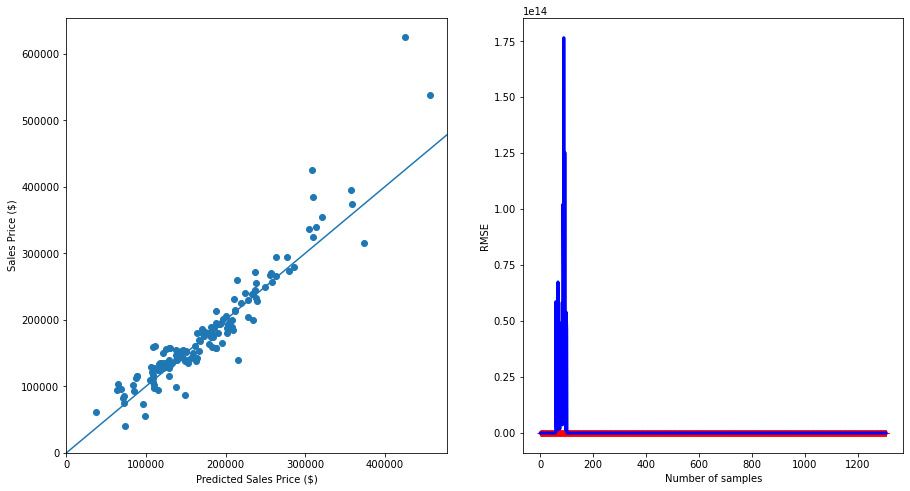

In [41]:
def analyze_linear_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    regressor = LinearRegressor()
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    
    # plot dignostics
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    BaseRegressorPlot.plot_predicted_vs_actual(axes[0], predicted, y_test)
    BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    print("RMSE:" + str(mean_squared_error(y_test, predicted, squared=False)))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)

analyze_linear_regression()

## Regularized Regressions
- Rigde Regression
- Lasso Regression
- Elstic Net

## Ridge Regression
In this section we analyze Ridge regression 

Ridge is regularized version of linear regression

It adds $ \Sigma_{\ i=1}^{\ n} \ \theta_i^{\ 2}$  regularization term to cost function to keep the model weight as samll as possible.

Ridge Regression cost function:

$$ J(\theta) \ = \ MSE(\theta) + \alpha \ \frac{1}{2} \Sigma_{\ i=1}^{\ n} \ \theta_i^{\ 2} $$

29406.413053315344


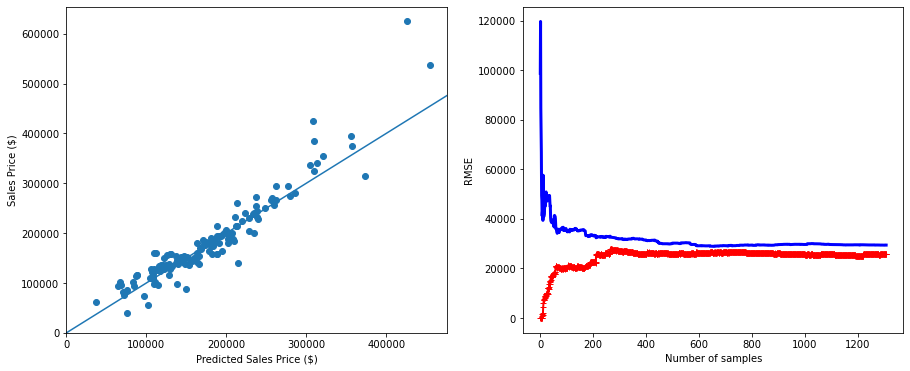

In [42]:
def analyze_ridge_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    regressor = RidgeRegressor()
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    
    # plot dignostics
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    BaseRegressorPlot.plot_predicted_vs_actual(axes[0], predicted, y_test)
    BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    print(mean_squared_error(y_test, predicted,squared=False))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)

analyze_ridge_regression()

## Lasso Regression

Lasso adds a regularization term to the cost function, but it uses the ℓ1 norm of the weight vector instead of half the square of the ℓ2 norm

Lasso Regression cost function

 $$ J(\theta) \ = \ MSE(\theta) + \alpha \  \Sigma_{\ i=1}^{\ n} \ |\theta_i| $$

An important characteristic of Lasso Regression is that it tends to eliminate the weights of the least important features (i.e., set them to zero).

In other words, Lasso Regression automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).

Note: Lasso regression has $\alpha$ as hyperparmeter which needs to be searched 

29340.796981186755


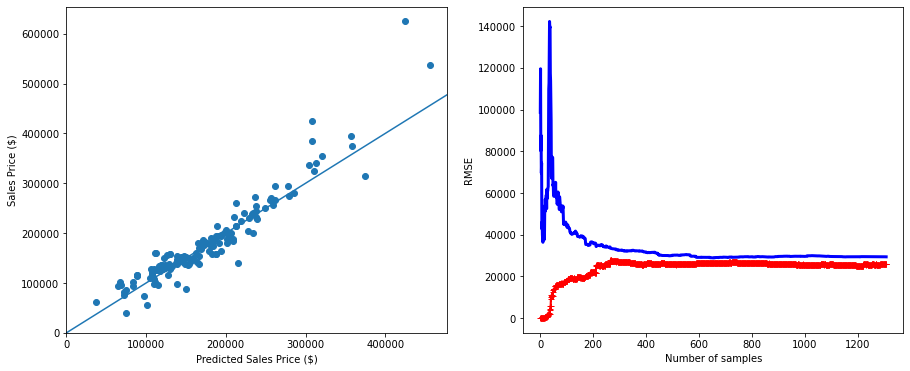

In [43]:
def analyze_lasso_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    regressor = LassoRegressor(alpha=10)
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    # plot dignostics
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    BaseRegressorPlot.plot_predicted_vs_actual(axes[0], predicted, y_test)
    BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    #plt.scatter(y_test, regressor.predict(X_test))
    print(mean_squared_error(y_test, predicted, squared=False))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)

analyze_lasso_regression()

## Elastic Net

For Elastic Net regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio r. When r = 0, Elastic Net is equivalent to Ridge Regression, and when r = 1, it is equivalent to Lasso Regression

Elastic Net cost function

$$ J(\theta) \ = \ MSE(\theta) + r \alpha \  \Sigma_{\ i=1}^{\ n} \ |\theta_i| +  \frac{1-r}{2} \alpha \ \Sigma_{\ i=1}^{\ n} \ \theta_i^{\ 2}$$

30925.94437179155


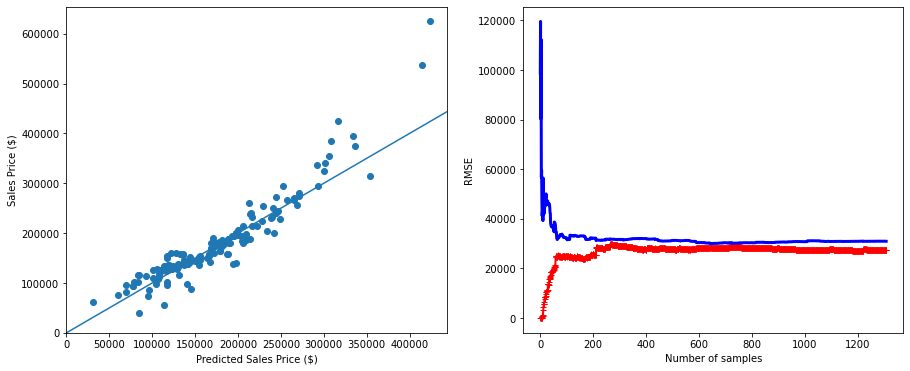

In [44]:
def analyze_elasticnet_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    regressor = ElasticNetRegressor(alpha=0.1, l1_ratio=0.5)
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    # plot dignostics
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    BaseRegressorPlot.plot_predicted_vs_actual(axes[0], predicted, y_test)
    BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    #plt.scatter(y_test, regressor.predict(X_test))
    print(mean_squared_error(y_test, predicted, squared=False))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)

analyze_elasticnet_regression()

## Decision Tree

37407.315384114045


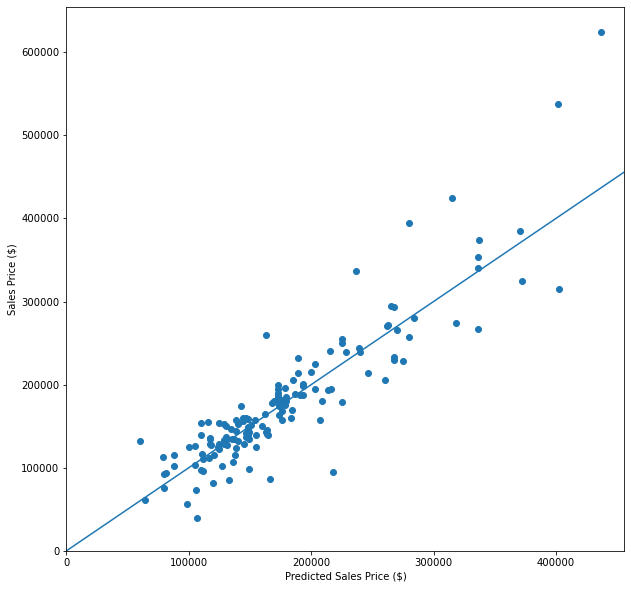

In [46]:
def analyze_decision_tree_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    regressor = DecisionTreeRegressor()
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    # plot dignostics
    fig, axes = plt.subplots(1, 1, figsize=(10,10))
    BaseRegressorPlot.plot_predicted_vs_actual(axes, predicted, y_test)
    #BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    #plt.scatter(y_test, regressor.predict(X_test))
    print(mean_squared_error(y_test, predicted, squared=False))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)


analyze_decision_tree_regression()

## Random Forest

30394.642471529554


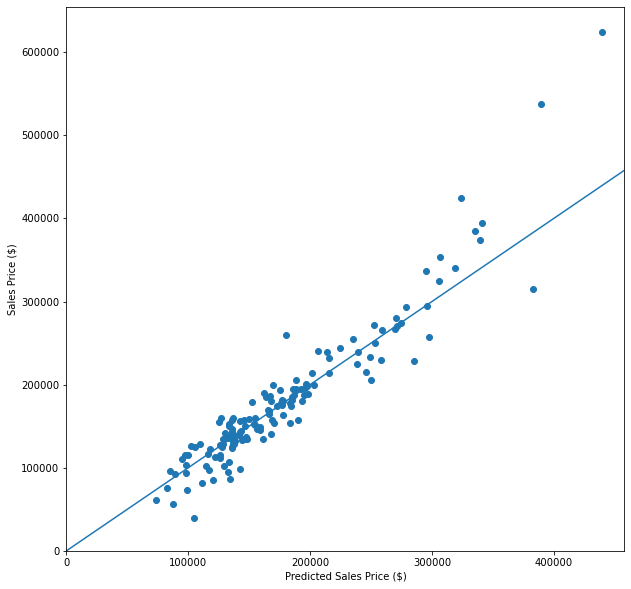

In [47]:
def analyze_random_forest_regression():
    X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()
    regressor = RandomForestRegressor()
    regressor.fit(X_train, y_train)
    predicted = regressor.get_predicted(X_test)

    # plot dignostics
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    BaseRegressorPlot.plot_predicted_vs_actual(axes, predicted, y_test)
    #BaseRegressorPlot.plot_learning_curves(axes[1], regressor, data_loader)
    #plt.scatter(y_test, regressor.predict(X_test))
    print(mean_squared_error(y_test, predicted, squared=False))
    RMSE=mean_squared_error(y_test, predicted, squared=False)
    RMSE_Scores.append(RMSE)


analyze_random_forest_regression()

## Wrapper method
This is a recursive feature elemination process to identify features importance

In [49]:
#reset the data to all features
df_fs_w = data_loader.df
X_train_fs_w, X_test_fs_w, y_train_fs_w, y_test_fs_w = train_test_split(
    data_loader.df_X, data_loader.df_y, test_size=0.10, random_state=1)



In [50]:
X_train = data_loader.data_prep(X_train_fs_w)
y_train = y_train_fs_w
X_test = data_loader.data_prep(X_test_fs_w)
y_test = y_test_fs_w



In [51]:

def rfe_fs(regressor, threshold=20):
    ''' Select the most important * features based on the model
         and use it as X_train & X_test'''
    selector = RFE(regressor, n_features_to_select=threshold, step=1)
    selector = selector.fit(X_train, y_train)
    selector_ind = selector.get_support()
    X_train_rfe = X_train.iloc[:, selector_ind]
    X_test_rfe = X_test.iloc[:, selector_ind]

    return X_train_rfe, X_test_rfe



In [52]:
#Initialize List to store RMSE scrores for wrapper function

RMSE_Scores_Wrapper=[]

RMSE =  38869.29681634367


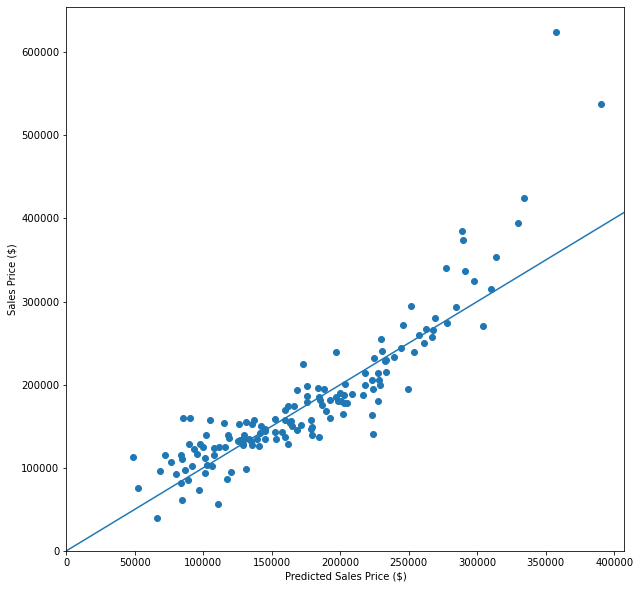

In [53]:
regressor = LinearRegression()

def analyze_regression():

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)
    predicted = regressor.predict(X_test_rfe)

    # plot dignostics
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    BaseRegressorPlot.plot_predicted_vs_actual(ax, predicted, y_test)

  
    print("RMSE = ", mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)


analyze_regression()


RMSE =  38612.29016113189


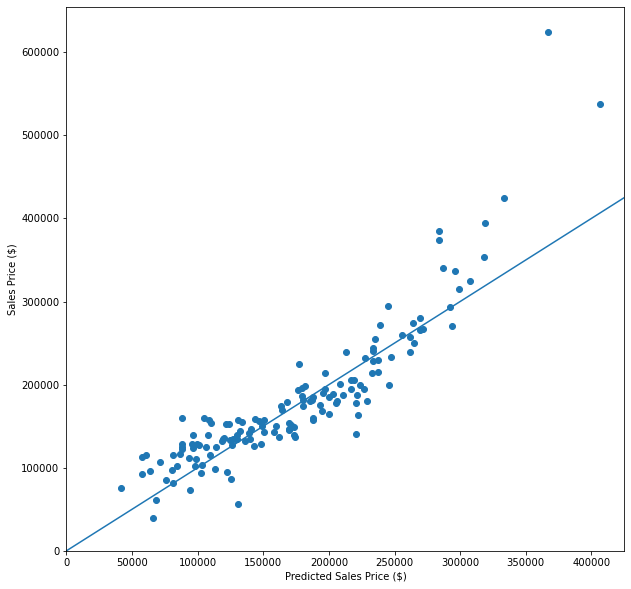

In [54]:
regressor = Ridge()


def analyze_regression():

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)
    predicted = regressor.predict(X_test_rfe)

    # plot dignostics
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    BaseRegressorPlot.plot_predicted_vs_actual(ax, predicted, y_test)

    print("RMSE = ", mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)


analyze_regression()


RMSE =  38774.47207026295


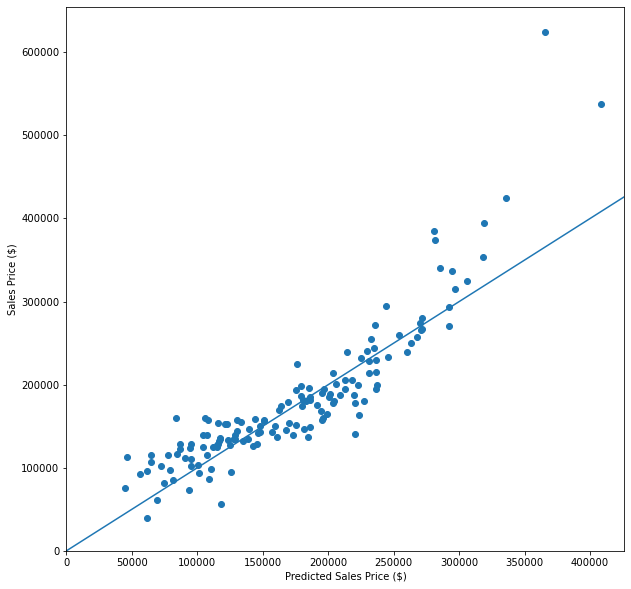

In [55]:
regressor = Lasso(alpha=0.1)

def analyze_regression():

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)
    predicted = regressor.predict(X_test_rfe)

    # plot dignostics
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    BaseRegressorPlot.plot_predicted_vs_actual(ax, predicted, y_test)
    print("RMSE = ", mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)

analyze_regression()


RMSE =  38878.259423239855


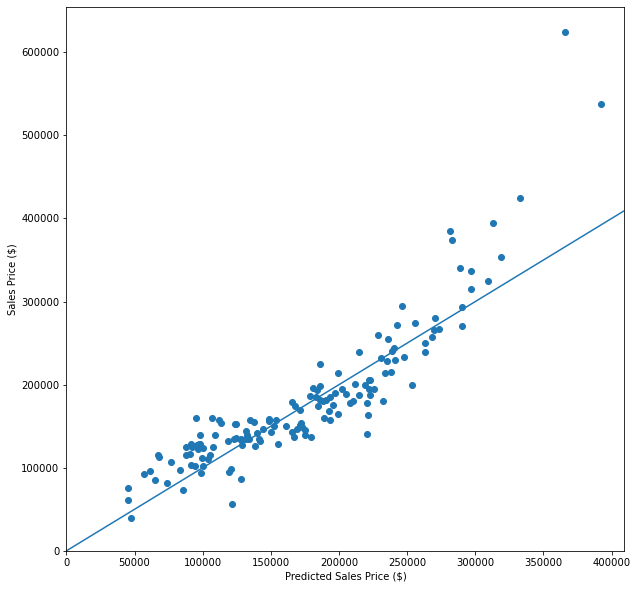

In [56]:
regressor = ElasticNet(alpha=0.1, l1_ratio=0.5)

def analyze_regression():

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)
    predicted = regressor.predict(X_test_rfe)

    # plot dignostics
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    BaseRegressorPlot.plot_predicted_vs_actual(ax, predicted, y_test)
    print("RMSE = ",mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)

analyze_regression()


RMSE =  37012.406267062426


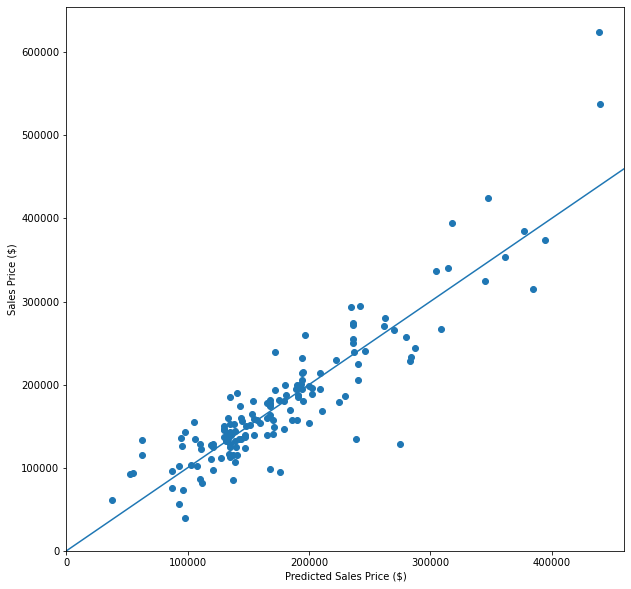

In [57]:
regressor = DTR()

def analyze_regression():
    
    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)
    predicted = regressor.predict(X_test_rfe)

    # plot dignostics
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    BaseRegressorPlot.plot_predicted_vs_actual(ax, predicted, y_test)
    print("RMSE = ",mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)

analyze_regression()


RMSE =  30327.848256054276


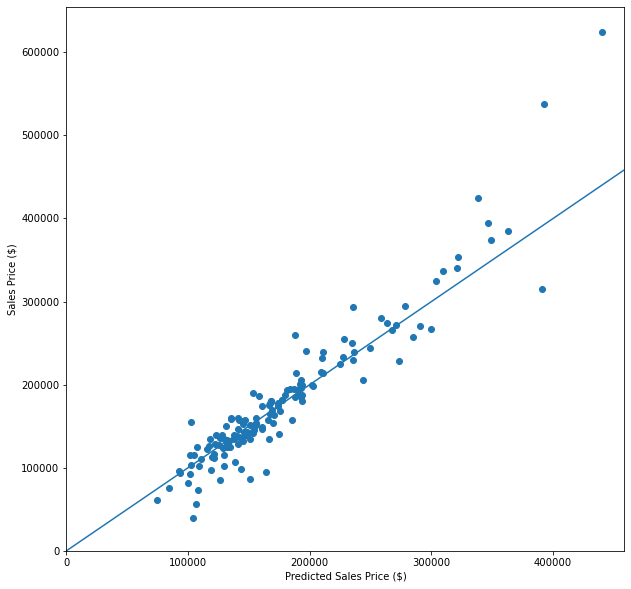

In [58]:
regressor = RFR()

def analyze_regression():

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    regressor.fit(X_train_rfe, y_train)
    predicted = regressor.predict(X_test_rfe)

    # plot dignostics
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    BaseRegressorPlot.plot_predicted_vs_actual(ax, predicted, y_test)
    print("RMSE = ",mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False))
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe), squared=False)
    RMSE_Scores_Wrapper.append(RMSE)

analyze_regression()



In [ ]:
from sklearn.model_selection import cross_validate

## Using sklearn cross_validate, set as 5 fold (same as default)

In [ ]:
def k_fold_cv(model): 
    score=cross_validate(model,X_train,y_train, cv=5, scoring="neg_mean_squared_error")['test_score']
    return score.mean()

k_fold_cv(LinearRegression()).mean()

# the model produces a metric which is  "negate MSE" so the larger the better. Since the metric is suppose
# to be used not for model selection but comparison

-719493426.361199

In [ ]:
regressor=[LinearRegression(),Ridge(),Lasso(alpha=0.1),ElasticNet(alpha=0.1, l1_ratio=0.5),DTR(),RFR()]

for model in regressor:
    score_avg=k_fold_cv(model)
    print("For {model} the average neg_mean_squared_error is {scores}".\
        format(model=model,scores=score_avg))



For LinearRegression() the average neg_mean_squared_error is -719493426.361199
For Ridge() the average neg_mean_squared_error is -719977485.0700648
For Lasso(alpha=0.1) the average neg_mean_squared_error is -719487860.8732598
For ElasticNet(alpha=0.1) the average neg_mean_squared_error is -718723878.6706324
For DecisionTreeRegressor() the average neg_mean_squared_error is -1438603710.976336
For RandomForestRegressor() the average neg_mean_squared_error is -662235708.0073715


## Hyperparameter tuning

In [ ]:
RMSE_Scores_Hyper=[]

In [ ]:
X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()

def ridge_model_HP():

    parameter_space = {
        "alpha": [1, 10, 100, 290, 500],
        "fit_intercept": [True, False],
        "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    }

    clf = GridSearchCV(Ridge(random_state=3), parameter_space, n_jobs=4,
                       cv=3)

    clf.fit(X_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)
    
    ridge_model = Ridge(random_state=3, **clf.best_params_)
    ridge_model.fit(X_train, y_train);

    y_pred = ridge_model.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False))
    RMSE=mean_squared_error(y_test, y_pred, squared=False)
    RMSE_Scores_Hyper.append(RMSE)
    
ridge_model_HP()

Best parameters:
{'alpha': 1, 'fit_intercept': False, 'solver': 'svd'}
29409.794982473635


### Hyperparamter tuning of Lasso Regressor

In [ ]:
X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()

def Lasso_model_HP():

    parameter_space = {
        "alpha":[0.0001,0.0001,0.001,0.1],
    }

    clf = GridSearchCV(Lasso(), parameter_space, n_jobs=4,cv=10)

    clf.fit(X_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)

    Lasso_model = Lasso(random_state=3, **clf.best_params_)
    Lasso_model.fit(X_train, y_train)

    y_pred = Lasso_model.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False))
    RMSE=mean_squared_error(y_test, y_pred, squared=False)
    RMSE_Scores_Hyper.append(RMSE)

Lasso_model_HP()



Best parameters:
{'alpha': 0.1}
29325.822246933545


### Hyperparameter tuning of ElasticNet

In [ ]:
X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()

def Elastic_model_HP():

    parameter_space = {
        "alpha": [1, 10, 100, 280, 500],
        "l1_ratio": [0.5, 1],
        "fit_intercept": [True, False],
    }

    clf = GridSearchCV(ElasticNet(random_state=3), parameter_space, 
                       n_jobs=4, cv=3)

    clf.fit(X_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)

    elasticNet_model = ElasticNet(random_state=3, **clf.best_params_)

    elasticNet_model.fit(X_train, y_train)

    y_pred = elasticNet_model.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False))
    RMSE=mean_squared_error(y_test, y_pred, squared=False)
    RMSE_Scores_Hyper.append(RMSE)

Elastic_model_HP()

Best parameters:
{'alpha': 10, 'fit_intercept': True, 'l1_ratio': 1}
29340.796981186755


### Hyperparameter tuning of Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()

def DT_model_HP():

    parameter_space =  {
            "criterion": ["mse", "friedman_mse", "mae"],
            "min_samples_split": [5, 18, 29, 50],
            "min_samples_leaf": [3, 7, 15, 25],
            "max_features": [20, 50, 150, 200, X_train.shape[1]],
        }

    clf = GridSearchCV(DecisionTreeRegressor(random_state=3), parameter_space, 
                       cv=3, n_jobs=4)

    clf.fit(X_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)

    dt_model = DecisionTreeRegressor(**clf.best_params_)

    dt_model.fit(X_train, y_train)

    y_pred = dt_model.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False))
    RMSE=mean_squared_error(y_test, y_pred, squared=False)
    RMSE_Scores_Hyper.append(RMSE)

DT_model_HP()

Best parameters:
{'criterion': 'mse', 'max_features': 60, 'min_samples_leaf': 7, 'min_samples_split': 18}
35942.875201619725


### Hyperparameter tuning of Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = data_loader.get_clean_encoded_data()

def RandomForest_model_HP():

    parameter_space = \
        {
            "n_estimators": [10, 100, 300, 600],
            "criterion": ["mse", "mae"],
            "max_depth": [7, 50, 254],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 5],
            "max_features": [19, 100, X_train.shape[1]],
            "bootstrap": [True, False],
        }

    clf = RandomizedSearchCV(RandomForestRegressor(random_state=3), 
                             parameter_space, cv=3, n_jobs=4, 
                             n_iter=10, random_state=3)

    clf.fit(X_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)

    rf_model = RandomForestRegressor(**clf.best_params_)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False))
    RMSE=mean_squared_error(y_test, y_pred, squared=False)
    RMSE_Scores_Hyper.append(RMSE)

RandomForest_model_HP()

Best parameters:
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 19, 'max_depth': 254, 'criterion': 'mse', 'bootstrap': False}
30091.672218002237


[Text(0.5, 0, 'RMSE (smaller is better)'),
 Text(0, 0.5, 'Model: Hyperparameter Tuning')]

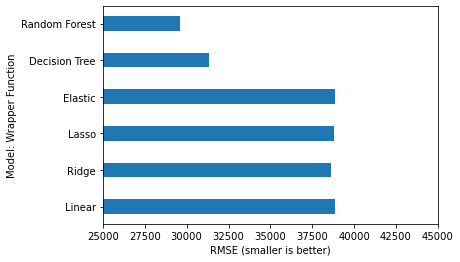

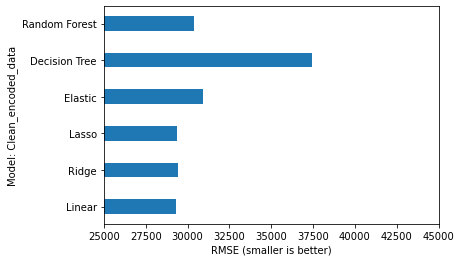

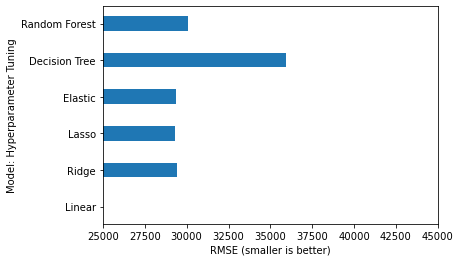

In [ ]:
x2 = ['Linear','Ridge','Lasso','Elastic','Decision Tree','Random Forest']
y = RMSE_Scores_Wrapper[:6]

fig, ax = plt.subplots()
plt.barh(y=range(len(x2)), tick_label=x2, width=y, height=0.4)
plt.xlim(25000,45000)
ax.set(xlabel="RMSE (smaller is better)", ylabel="Model: Wrapper Function")

x1 = ['Linear','Ridge','Lasso','Elastic','Decision Tree','Random Forest']
y = RMSE_Scores[:6]

fig, ax = plt.subplots()
plt.barh(y=range(len(x1)), tick_label=x1, width=y, height=0.4)
plt.xlim(25000,45000)
ax.set(xlabel="RMSE (smaller is better)", ylabel="Model: Clean_encoded_data")


RMSE_Scores_Hyper.insert(0,0)
x3 = ['Linear','Ridge','Lasso','Elastic','Decision Tree','Random Forest']
y = RMSE_Scores_Hyper[-6:]

fig, ax = plt.subplots()
plt.barh(y=range(len(x3)), tick_label=x3, width=y, height=0.4)
plt.xlim(25000,45000)
ax.set(xlabel="RMSE (smaller is better)", ylabel="Model: Hyperparameter Tuning")

In [ ]:
df = pd.DataFrame({
            'Regressor': x1,
            'Wrapper':RMSE_Scores_Wrapper[:6],
            'Baseline': RMSE_Scores[:6],
            'Hyperparameter_tuning':RMSE_Scores_Hyper[-6:]
            })
df = df.style.set_caption('Comparison of RMSE Scores for various Regressors with, Baseline, Wrapper Function and Hyperparameter tuning')
display(df)

,Regressor,Wrapper,Baseline,Hyperparameter_tuning
0,Linear,38869.296816,29325.596202,0.000000
1,Ridge,38612.290161,29406.413053,29409.794982
2,Lasso,38774.472070,29340.796981,29325.822247
3,Elastic,38878.259423,30925.944372,29340.796981
4,Decision Tree,31351.995253,37407.315384,35942.875202
5,Random Forest,29594.162690,30394.642472,30091.672218
